In [1060]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

df = pd.read_csv("QQQ_base-QQQ_base.csv")
df = df.drop(df.columns[[58, 59]], axis=1) # Removing two columns where there's no data

df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").set_index("Date")

df.head()
ret_col = "QQQ_today_close_to_tmrw_close_return"

In [1061]:
signal_cols = [c for c in df.columns if c.startswith("LT_SIG") or c.startswith("ST_SIG")]
baseline_ret = df["baseline_strategy_return"]

In [1062]:
def compute_rolling_golden_score(df,
                                 signal_cols,
                                 ret_col,
                                 lookback,
                                 n_top,
                                 use_corr_weights=True):
    """
    For each date t >= lookback:
      - use the previous `lookback` days (t-lookback ... t-1)
      - compute correlation of each signal with return
      - pick top/bottom `n_top` signals
      - build a bullish - bearish score for date t
    For t < lookback, score is 0.
    """
    dates = df.index
    golden = pd.Series(0.0, index=dates, name="golden_score")

    for i in range(lookback, len(df)):
        window = df.iloc[i - lookback:i]   # since we're only using past values, there is no lookahead

        # correlations in that window
        corrs = window[signal_cols].corrwith(window[ret_col]).dropna()
        if corrs.empty:
            continue

        corrs_sorted = corrs.sort_values(ascending=False)
        bullish = corrs_sorted.head(n_top)   # top +ve
        bearish = corrs_sorted.tail(n_top)   # most -ve

        today = dates[i]
        bull_vals = df.loc[today, bullish.index].values
        bear_vals = df.loc[today, bearish.index].values

        if use_corr_weights:
            # weights proportional to |corr|
            w_bull = bullish.clip(lower=0)
            if w_bull.abs().sum() == 0:
                w_bull[:] = 1.0
            w_bull = w_bull / w_bull.abs().sum()

            w_bear = bearish.abs()
            if w_bear.sum() == 0:
                w_bear[:] = 1.0
            w_bear = w_bear / w_bear.sum()

            bull_score = np.dot(bull_vals, w_bull.values)
            bear_score = np.dot(bear_vals, w_bear.values)
        else:
            bull_score = bull_vals.sum()
            bear_score = bear_vals.sum()

        golden[today] = bull_score - bear_score

    return golden.fillna(0.0)


In [1063]:
df["golden_score"] = compute_rolling_golden_score(
    df,
    signal_cols=signal_cols,
    ret_col=ret_col,
    lookback=100, # 100 of past values to calculate correlation.
    n_top=10, # Taking the top 20% of signals
    use_corr_weights=True,
)


In [1064]:
def perf_stats(r, freq=252):
    ann_ret = (1 + r).prod()**(freq/len(r)) - 1
    ann_vol = r.std() * np.sqrt(freq)
    sharpe = (ann_ret - 0.048) / ann_vol if ann_vol != 0 else np.nan
    max_dd = ((1 + r).cumprod().cummax() - (1 + r).cumprod()).max() / (1 + r).cumprod().cummax().max()
    return pd.Series({"ann_ret": ann_ret, "ann_vol": ann_vol, "sharpe": sharpe, "max_dd": max_dd})

perf_stats(df[ret_col]), perf_stats(baseline_ret)

(ann_ret    0.180186
 ann_vol    0.249945
 sharpe     0.528863
 max_dd     0.339484
 dtype: float64,
 ann_ret    0.560898
 ann_vol    0.226313
 sharpe     2.266322
 max_dd     0.130712
 dtype: float64)

In [1065]:
lt_cols = [c for c in df.columns if c.startswith("LT_SIG")]
st_cols = [c for c in df.columns if c.startswith("ST_SIG")]

df["n_LT_on"] = df[lt_cols].sum(axis=1)
df["n_LT_on"] = df["n_LT_on"].rolling(window=5, min_periods=1).max()
df["n_ST_on"] = df[st_cols].sum(axis=1)
df["n_total_on"] = df["n_LT_on"] + df["n_ST_on"]

cols = ["n_LT_on", "n_ST_on", "n_total_on"]

In [1066]:
split_date = "2022-01-01"
train = df[:split_date].copy()
test  = df[split_date:].copy()


In [1067]:
def compute_exposure_formula(df, x, y, t0, k, w_golden,
                             v0=20.0, # Because the median was around 20
                             min_short=-100.0,
                             max_long=150.0):
    n_lt  = df["n_LT_on"].values
    n_st  = df["n_ST_on"].values
    vix   = df["VIX"].values
    g_sig = df["golden_score"].values  # rolling, time-varying

    # 1) signal strength: counts + rolling golden rule
    signal_strength = (n_lt / x) + (n_st / y) + w_golden * g_sig - t0

    # 2) volatility regime factor
    regime_factor = np.exp(-k * (vix - v0)) # always positive

    raw_exp = 100* signal_strength*regime_factor  # scaled it by 100 because without it, 
                                                   #the exposure values were very small and 
                                                   # so the returns and max dd were also proportionately small

    # 3) clipped to allowed range
    exp_clipped = np.clip(raw_exp, min_short, max_long)
    return pd.Series(exp_clipped, index=df.index)


In [1068]:
df["golden_shift"] = df["golden_score"].shift(0) 
print(df[["golden_shift", ret_col]].corr())

print(df[["golden_score", "n_LT_on", "n_ST_on"]].corr())


                                      golden_shift  \
golden_shift                              1.000000   
QQQ_today_close_to_tmrw_close_return     -0.080383   

                                      QQQ_today_close_to_tmrw_close_return  
golden_shift                                                     -0.080383  
QQQ_today_close_to_tmrw_close_return                              1.000000  
              golden_score   n_LT_on   n_ST_on
golden_score      1.000000 -0.114500 -0.300536
n_LT_on          -0.114500  1.000000 -0.123867
n_ST_on          -0.300536 -0.123867  1.000000


Too much correlation between the golden score and the signals, so it may be better to drop this parameter.

In [1069]:

best_sharpe = -1e9
best_params = None
best_train_ret = None

def strat_returns_from_exposure(exp_series, qqq_ret_series):
    return (exp_series / 100.0) * qqq_ret_series

# bounds: [x, y, t0, k, w_golden]
lower = np.array([1,  3, 0.0, 0.001, 0.0])
upper = np.array([7.0, 10, 5.0, 0.1, 10.0])

def fitness(params):
    x, y, t0, k, w_g = params
    if x <= 0 or y <= 0:
        return -1e9

    exp_train = compute_exposure_formula(train, x, y, t0, k, w_g)
    ret_train = strat_returns_from_exposure(exp_train, train[ret_col])
    stats = perf_stats(ret_train)
    return stats["sharpe"]




## Optimization with Genetic Algorithm

In [1070]:

np.random.seed(10)
pop_size   = 40   # number of candidate solutions
n_gen      = 20   # number of generations (only 20 so that we dont over optimize on the small training set)
elite_frac = 0.2  # top % kept as elites
mut_prob   = 0.3  # probability of mutation per child
mut_scale  = 0.1  # mutation step size (relative to parameter range)

n_elite = int(pop_size * elite_frac)

dim = len(lower)
pop = np.random.rand(pop_size, dim) * (upper - lower) + lower

for gen in range(n_gen):
    fits = np.array([fitness(ind) for ind in pop])

    best_idx = np.argmax(fits)
    best_sharpe_gen = fits[best_idx]
    best_params_gen = pop[best_idx]

    print(f"Gen {gen:3d} | best Sharpe: {best_sharpe_gen:.4f} | "
          f"x={best_params_gen[0]:.3f}, y={best_params_gen[1]:.3f}, "
          f"t0={best_params_gen[2]:.3f}, k={best_params_gen[3]:.3f}, golden={best_params_gen[4]:.3f}")

    shifted = fits - fits.min() + 1e-6
    probs = shifted / shifted.sum()

    elite_idx = np.argsort(fits)[-n_elite:]
    elites = pop[elite_idx]

    children = []
    while len(children) < pop_size - n_elite:

        i1, i2 = np.random.choice(pop_size, size=2, p=probs)
        p1, p2 = pop[i1], pop[i2]

        alpha = np.random.rand()
        child = alpha * p1 + (1 - alpha) * p2

        if np.random.rand() < mut_prob:
            noise = np.random.normal(
                scale=mut_scale * (upper - lower)
            )
            child = child + noise

        child = np.clip(child, lower, upper)
        children.append(child)

    pop = np.vstack([elites, np.array(children)])

fits = np.array([fitness(ind) for ind in pop])
best_idx = np.argmax(fits)
best_sharpe = fits[best_idx]
best_params = pop[best_idx]

print("\n=== GA result on TRAIN ===")
print("Best Sharpe:", best_sharpe)
print("Best params (x, y, t0, k, golden):", best_params)


Gen   0 | best Sharpe: 1.1693 | x=1.240, y=6.006, t0=1.575, k=0.064, golden=3.463
Gen   1 | best Sharpe: 1.1693 | x=1.240, y=6.006, t0=1.575, k=0.064, golden=3.463
Gen   2 | best Sharpe: 1.3597 | x=4.651, y=4.827, t0=0.701, k=0.050, golden=0.005
Gen   3 | best Sharpe: 1.3597 | x=4.651, y=4.827, t0=0.701, k=0.050, golden=0.005
Gen   4 | best Sharpe: 1.3597 | x=4.651, y=4.827, t0=0.701, k=0.050, golden=0.005
Gen   5 | best Sharpe: 1.5834 | x=1.560, y=3.365, t0=1.001, k=0.019, golden=2.606
Gen   6 | best Sharpe: 1.5834 | x=1.560, y=3.365, t0=1.001, k=0.019, golden=2.606
Gen   7 | best Sharpe: 1.5834 | x=1.560, y=3.365, t0=1.001, k=0.019, golden=2.606
Gen   8 | best Sharpe: 1.5834 | x=1.560, y=3.365, t0=1.001, k=0.019, golden=2.606
Gen   9 | best Sharpe: 1.7059 | x=1.860, y=5.058, t0=0.991, k=0.042, golden=0.000
Gen  10 | best Sharpe: 1.7059 | x=1.860, y=5.058, t0=0.991, k=0.042, golden=0.000
Gen  11 | best Sharpe: 1.7305 | x=2.144, y=3.814, t0=0.688, k=0.013, golden=1.257
Gen  12 | best S

Since the genetic algorithm is pushing the golden score weight to zero, this confirms that the feature was basically redundant. But still, it was worth checking if there were some signals that were much more accurate predictors of the returns.

The x and y parameter values obtained are intuitive because we have about 4 times as many ST signals than LT signals. The small value of k means volatility scales our exposure a bit, but not too much that we lose out on gains.

In [1071]:

x_best, y_best, t0_best, k_best, wg_best = best_params

exp_full = compute_exposure_formula(
    df,
    x_best,
    y_best,
    t0_best,
    k_best,
    wg_best,
)

ret_full = strat_returns_from_exposure(exp_full, df[ret_col])

baseline = df["baseline_strategy_return"]

print("Baseline (full):")
print(perf_stats(baseline))

print("\nGA-optimized strategy with rolling golden rule (full):")
print(perf_stats(ret_full))

train_mask = df.index <= split_date
test_mask  = df.index >= split_date

print("\nTRAIN GA strategy:")
print(perf_stats(ret_full[train_mask]))

print("\nTEST GA strategy:")
print(perf_stats(ret_full[test_mask]))


Baseline (full):
ann_ret    0.560898
ann_vol    0.226313
sharpe     2.266322
max_dd     0.130712
dtype: float64

GA-optimized strategy with rolling golden rule (full):
ann_ret    0.728849
ann_vol    0.299213
sharpe     2.275466
max_dd     0.164218
dtype: float64

TRAIN GA strategy:
ann_ret    0.707210
ann_vol    0.292702
sharpe     2.252156
max_dd     0.131873
dtype: float64

TEST GA strategy:
ann_ret    0.773220
ann_vol    0.312192
sharpe     2.322989
max_dd     0.164218
dtype: float64


The Sharpe is maintained in the test set too. I manually iterated this by changing the random seed a few times and noticed that the sharpe is consistently above 2 in both training and test sets, and so this is not overfitting.

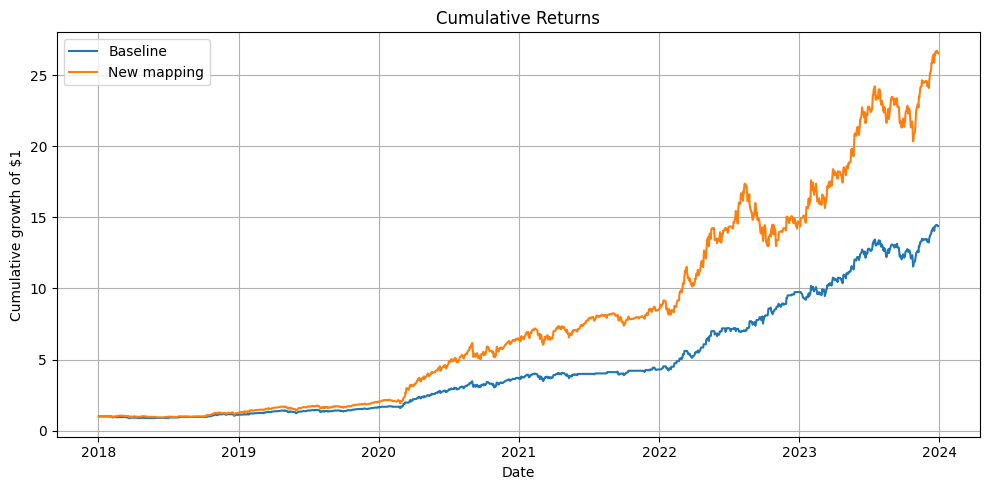

In [1072]:
import matplotlib.pyplot as plt
calculated_exposure = compute_exposure_formula(train, best_params[0], best_params[1], best_params[2], best_params[3], best_params[4])
cum_baseline = (1 + baseline_ret).cumprod()
cum_new      = (1 + ret_full).cumprod()

plt.figure(figsize=(10, 5))
plt.plot(cum_baseline.index, cum_baseline, label="Baseline")
plt.plot(cum_new.index, cum_new, label="New mapping")

plt.title("Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative growth of $1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### How I tried to avoid overfitting:

1) Respecting the time axis (no look-ahead)

    Every exposure for day t only uses information available up to t (signals, VIX, rolling “golden score” built from the previous lookback days).

    Rolling correlations and golden-score weights are recalculated using only past windows, never the full dataset. (even though we finally did not really end up using it)

2) Simple, low-dimensional model

    The exposure is a transparent parametric formula with a small number of scalar parameters 

    No complex ML model, no trees or neural nets – just one interpretable mapping from signal counts and volatility to leverage.

3) Train / test separation

    I split the data into a train period and a test period.

    The genetic algorithm only optimizes parameters on the train set; the test set is kept completely out-of-sample and used only once at the end to evaluate performance.
    
    Equally importantly, I made sure not to keep trying different values of $v_0$, lookback period, number of top bullish and bearish signals, scaling factor for exposure, because then that would be overfitting as I am trying to manually fit the test and training data with human trial and error.

4) Robustness checks

    I checked that performance is reasonably close in train vs. test (Sharpe doesn’t collapse out-of-sample).

    I also re-ran the GA with different random seeds and saw similar parameter values and Sharpe ratios, which suggests the result isn’t just a single lucky run.

Still, given the limited sample size, some overfitting risk is unavoidable, but the above choices are meant to keep the final strategy as robust and interpretable as possible.